In [1]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 66 kB 3.0 MB/s eta 0:00:011
     |████████████████████████████████| 58 kB 3.4 MB/s eta 0:00:011
     |████████████████████████████████| 244 kB 7.2 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=1b631117c436f2623c6c5a759797b02f44ad03ed13877867e358ecf3b6779cd4
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=9d9a6df2a4ee96d03a382c2e3a89c994e7c6d89851c0166bc0525ea3f551de2e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sys, os, random, time, re
import gc
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
import tifffile as tiff
from tqdm.notebook import tqdm

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import albumentations as albu

%matplotlib inline

In [3]:
from pathlib import Path

In [4]:
DATA_DIR = Path('data')
assert DATA_DIR.exists()
TRAIN_DATA_DIR = DATA_DIR/'train'
assert TRAIN_DATA_DIR.exists()
TEST_DATA_DIR = DATA_DIR/'test'
assert TEST_DATA_DIR.exists()
TRAIN_SAVE_DIR = DATA_DIR/'train_tiles'
TEST_SAVE_DIR = DATA_DIR/'test_tiles'
TILE_SIZE = 256
REDUCE_RATE = 4

if not os.path.exists(TRAIN_SAVE_DIR):
    os.mkdir(TRAIN_SAVE_DIR)

if not os.path.exists(TEST_SAVE_DIR):
    os.mkdir(TEST_SAVE_DIR)

In [5]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

In [6]:
TILE_SIZE = 256
REDUCE_RATE = 4
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 20
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### train/test patches generation

In [7]:
sample_df = pd.read_csv(DATA_DIR/'sample_submission.csv')
sample_df

,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [8]:
def display_pil_images(
    images, 
    masks=None,
    labels=None,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=9):

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
        if masks is not None:
            masks= masks[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    
    if masks is not None:
        for i, (image, mask) in enumerate(zip(images,masks)):
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image)
            plt.imshow(mask, cmap='coolwarm', alpha=0.5)
            
            if labels is not None:
                plt.title(labels[i], fontsize=label_font_size); 
            
    else:
        for i, image in enumerate(images):
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image)
        
            if labels is not None:
                plt.title(labels[i], fontsize=label_font_size); 

        
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = 0.7, expected_shape = (TILE_SIZE, TILE_SIZE)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

def extract_train_tiles(sample_img_path, rle_mask_sample, idx):
    print(idx)
    sample_image = tiff.imread(sample_img_path)
    
    if idx in ['e79de561c', '095bf7a1f', '54f2eec69', '1e2425f28']:
        sample_image = np.transpose(sample_image.squeeze(), (1,2,0))

        
    sample_mask = rle2mask(rle_mask_sample, (sample_image.shape[1], sample_image.shape[0]))
    print(f"Original Tiff image shape: {sample_image.shape}")
    
    pad0 = (REDUCE_RATE*TILE_SIZE - sample_image.shape[0]%(REDUCE_RATE*TILE_SIZE))%(REDUCE_RATE*TILE_SIZE)
    pad1 = (REDUCE_RATE*TILE_SIZE - sample_image.shape[1]%(REDUCE_RATE*TILE_SIZE))%(REDUCE_RATE*TILE_SIZE)
    
    sample_image = np.pad(sample_image,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                   constant_values=0)
    sample_mask = np.pad(sample_mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],
                  constant_values=0)
        
    sample_image = cv.resize(sample_image,(sample_image.shape[1]//REDUCE_RATE,sample_image.shape[0]//REDUCE_RATE),
                             interpolation = cv.INTER_AREA)
    
    sample_mask = cv.resize(sample_mask,(sample_mask.shape[1]//REDUCE_RATE,sample_mask.shape[0]//REDUCE_RATE),
                             interpolation = cv.INTER_AREA)
    
    print(f"Reduced Tiff image shape: {sample_image.shape}")
    
    tiles, masks, paths = [], [], []
    for x in range(0,sample_image.shape[0],TILE_SIZE):
        for y in range(0,sample_image.shape[1],TILE_SIZE):
            sub_image = np.float32(sample_image[x:x+TILE_SIZE,y:y+TILE_SIZE])
            sub_mask = sample_mask[x:x+TILE_SIZE,y:y+TILE_SIZE]
            if is_tile_contains_info(sub_image, (50, 220), 0.7, (TILE_SIZE,TILE_SIZE, 3))[0]:
                tiles.append(sub_image)
                masks.append(sub_mask)
            else:
                continue
    
    if not os.path.exists(os.path.join(TRAIN_SAVE_DIR, idx)):
        os.mkdir(os.path.join(TRAIN_SAVE_DIR, idx))

    count = 0
    for tile,mask in zip(tiles,masks):
        cv.imwrite(os.path.join(TRAIN_SAVE_DIR, idx, f"img_{count}.png"), tile)
        cv.imwrite(os.path.join(TRAIN_SAVE_DIR, idx, f"mask_{count}.png"), mask)
        paths.append((os.path.join(TRAIN_SAVE_DIR, idx, f"img_{count}.png"), 
                      os.path.join(TRAIN_SAVE_DIR, idx, f"mask_{count}.png")))

        count += 1
            
    print(f"Length tiles", len(tiles))
    gc.collect()
    
    return paths

def extract_test_tiles(sample_img_path, idx):
    print(idx)
    sample_image = tiff.imread(sample_img_path)
    
    if idx in ['26dc41664', 'c68fe75ea']:
        sample_image = np.transpose(sample_image.squeeze(), (1,2,0))

    print(f"Original Tiff image shape: {sample_image.shape}")
    
    pad0 = (REDUCE_RATE*TILE_SIZE - sample_image.shape[0]%(REDUCE_RATE*TILE_SIZE))%(REDUCE_RATE*TILE_SIZE)
    pad1 = (REDUCE_RATE*TILE_SIZE - sample_image.shape[1]%(REDUCE_RATE*TILE_SIZE))%(REDUCE_RATE*TILE_SIZE)
    
    sample_image = np.pad(sample_image,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                   constant_values=0)
    
    sample_image = cv.resize(sample_image,(sample_image.shape[1]//REDUCE_RATE,sample_image.shape[0]//REDUCE_RATE),
                             interpolation = cv.INTER_AREA)
    
    print(f"Reduced Tiff image shape: {sample_image.shape}")
    
    tiles, paths = [], []
    for x in range(0,sample_image.shape[0],TILE_SIZE):
        for y in range(0,sample_image.shape[1],TILE_SIZE):
            sub_image = np.float32(sample_image[x:x+TILE_SIZE,y:y+TILE_SIZE])
            tiles.append(sub_image)
    
    if not os.path.exists(os.path.join(TEST_SAVE_DIR, idx)):
        os.mkdir(os.path.join(TEST_SAVE_DIR, idx))

    count = 0
    for tile in tiles:
        cv.imwrite(os.path.join(TEST_SAVE_DIR, idx, f"img_{count}.png"), tile)
        paths.append(os.path.join(TEST_SAVE_DIR, idx, f"img_{count}.png"))
        count += 1
            
    print(f"Length tiles", len(tiles))
    gc.collect()
    
    return paths

In [9]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), encoding='utf-8')
train_df

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [10]:
sample_df = pd.read_csv(DATA_DIR/'sample_submission.csv')
sample_df

,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [11]:
train_img_paths = [os.path.join(TRAIN_DATA_DIR, item + '.tiff') for item in train_df['id']]
test_img_paths = [os.path.join(TEST_DATA_DIR, item + '.tiff') for item in sample_df['id']]

print(train_img_paths)
print(test_img_paths)

['data/train/2f6ecfcdf.tiff', 'data/train/aaa6a05cc.tiff', 'data/train/cb2d976f4.tiff', 'data/train/0486052bb.tiff', 'data/train/e79de561c.tiff', 'data/train/095bf7a1f.tiff', 'data/train/54f2eec69.tiff', 'data/train/1e2425f28.tiff']
['data/test/b9a3865fc.tiff', 'data/test/b2dc8411c.tiff', 'data/test/26dc41664.tiff', 'data/test/c68fe75ea.tiff', 'data/test/afa5e8098.tiff']


In [12]:
!rm -rf {DATA_DIR/'train_tiles'}
!rm -rf {DATA_DIR/'test_tiles'}
!mkdir {DATA_DIR/'train_tiles'}
!mkdir {DATA_DIR/'test_tiles'}

In [13]:
%%time

all_train_paths = []
for idx, train_img_path in enumerate(train_img_paths):
    paths = extract_train_tiles(train_img_path, 
                                train_df['encoding'].values[idx], 
                                train_df['id'].values[idx])
    all_train_paths.extend(paths)
    
print("Length of all samples:", len(all_train_paths))

2f6ecfcdf
Original Tiff image shape: (31278, 25794, 3)
Reduced Tiff image shape: (7936, 6656, 3)
Length tiles 252
aaa6a05cc
Original Tiff image shape: (18484, 13013, 3)
Reduced Tiff image shape: (4864, 3328, 3)
Length tiles 87
cb2d976f4
Original Tiff image shape: (34940, 49548, 3)
Reduced Tiff image shape: (8960, 12544, 3)
Length tiles 561
0486052bb
Original Tiff image shape: (25784, 34937, 3)
Reduced Tiff image shape: (6656, 8960, 3)
Length tiles 290
e79de561c
Original Tiff image shape: (16180, 27020, 3)
Reduced Tiff image shape: (4096, 6912, 3)
Length tiles 373
095bf7a1f
Original Tiff image shape: (38160, 39000, 3)
Reduced Tiff image shape: (9728, 9984, 3)
Length tiles 1049
54f2eec69
Original Tiff image shape: (30440, 22240, 3)
Reduced Tiff image shape: (7680, 5632, 3)
Length tiles 554
1e2425f28
Original Tiff image shape: (26780, 32220, 3)
Reduced Tiff image shape: (6912, 8192, 3)
Length tiles 586
Length of all samples: 3752
CPU times: user 2min 55s, sys: 21.8 s, total: 3min 17s
Wall

In [14]:
%%time

all_test_paths = []
for idx, test_img_path in enumerate(test_img_paths):
    paths = extract_test_tiles(test_img_path, 
                               sample_df['id'].values[idx])
    all_test_paths.extend(paths)
    
print("Length of all samples:", len(all_test_paths))

b9a3865fc
Original Tiff image shape: (31295, 40429, 3)
Reduced Tiff image shape: (7936, 10240, 3)
Length tiles 1240
b2dc8411c
Original Tiff image shape: (14844, 31262, 3)
Reduced Tiff image shape: (3840, 7936, 3)
Length tiles 465
26dc41664
Original Tiff image shape: (38160, 42360, 3)
Reduced Tiff image shape: (9728, 10752, 3)
Length tiles 1596
c68fe75ea
Original Tiff image shape: (26840, 49780, 3)
Reduced Tiff image shape: (6912, 12544, 3)
Length tiles 1323
afa5e8098
Original Tiff image shape: (36800, 43780, 3)
Reduced Tiff image shape: (9216, 11008, 3)
Length tiles 1548
Length of all samples: 6172
CPU times: user 1min 33s, sys: 16.4 s, total: 1min 50s
Wall time: 2min 56s


### Result

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


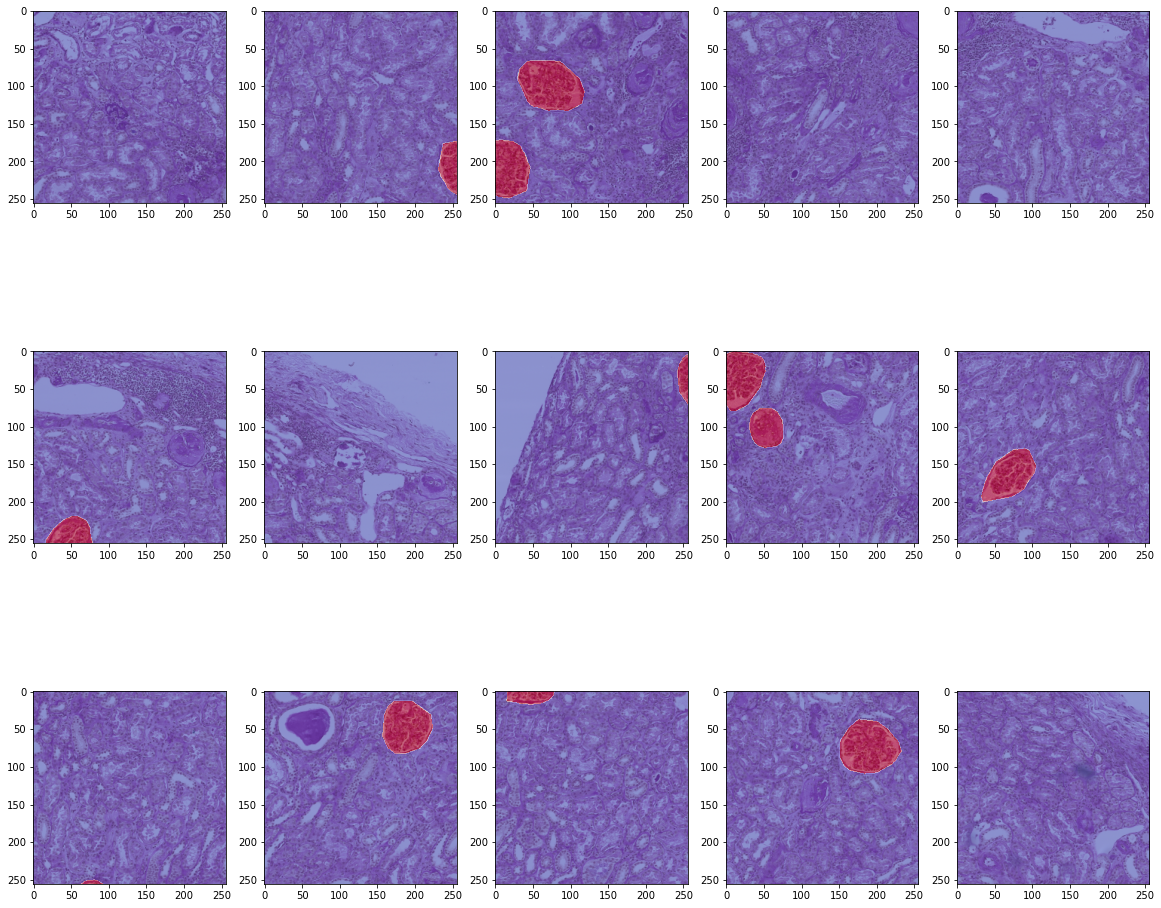

In [15]:
imgs = [Image.open(img_path) for img_path, _ in all_train_paths]
masks = [Image.open(mask_path) for _, mask_path in all_train_paths]
display_pil_images(imgs[:15], masks[:15])

Showing 15 images of 50:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


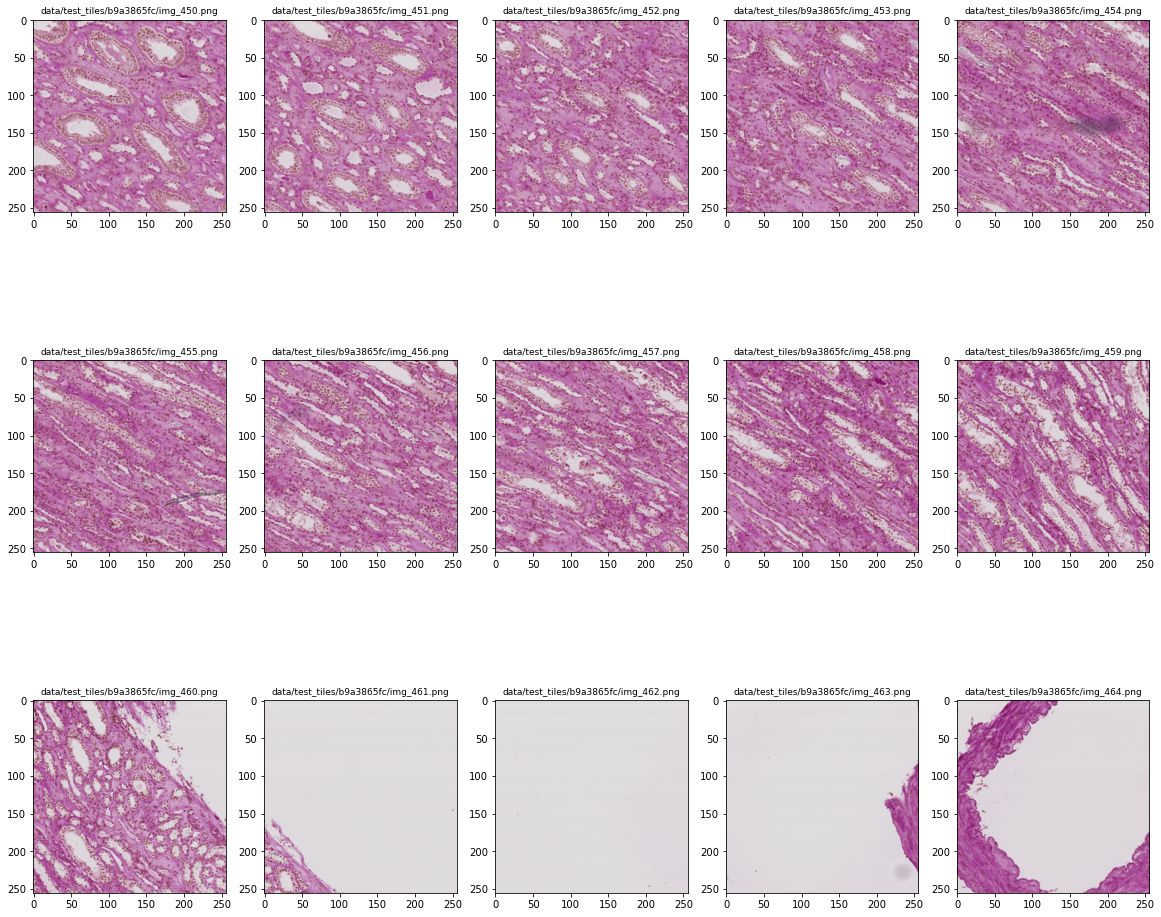

In [16]:
imgs = [Image.open(img_path) for img_path in all_test_paths]
display_pil_images(imgs[450:500], labels=all_test_paths[450:500])